# Training and Evaluating Xception Model
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

# Imports

In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [20]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
utils = tf.contrib.keras.utils
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
applications = tf.contrib.keras.applications

# Load Pre-Trained Xception Model

In [3]:
# load pre-trained Xception model and exclude top dense layer
base_model = applications.Xception(include_top=False,
                                   weights='imagenet',
                                   input_shape=(299,299,3),
                                   pooling='avg')

In [4]:
print("Model input shape: {}\n".format(base_model.input_shape))
print("Model output shape: {}\n".format(base_model.output_shape))
print("Model number of layers: {}\n".format(len(base_model.layers)))

Model input shape: (None, 299, 299, 3)

Model output shape: (None, 2048)

Model number of layers: 133



# Fine-tune Xception Model

In [5]:
def fine_tune_Xception(base_model):
    
    # output of convolutional layers
    x = base_model.output

    # final Dense layer with 4 classess
    outputs = layers.Dense(4, activation='softmax')(x)

    # define model with base_model's input
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of early layers
    # to ease training (mostly feature layers which does not need to be re-trained)
    for layer in model.layers[:40]:
        layer.trainable = False
    
    return model

# Compile Model

In [6]:
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.RMSprop(lr=0.0001)
    
    # metrics
    metric = [metrics.categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
        
    return model

# Inspect Model Architecture

In [21]:
model = fine_tune_Xception(base_model)
model = compile_model(model)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# Image Preprocessing And Augmentation

In [22]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    
    # 'RGB'->'BGR'
    x = x[..., ::-1]
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x


train_datagen = preprocessing_image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(preprocessing_function=preprocess_image)

In [23]:
BASE_DIR = "/Users/marvinbertin/Github/marvin/ImageNet_Utils"

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/train"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/validation"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 2677 images belonging to 4 classes.
Found 668 images belonging to 4 classes.


# Train Model on ImageNet Dataset

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=80,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10
80/80 [==============================] - 121s - loss: 0.9725 - categorical_accuracy: 0.5895 - val_loss: 12.2145 - val_categorical_accuracy: 0.2422
Epoch 2/10
80/80 [==============================] - 119s - loss: 0.8422 - categorical_accuracy: 0.6576 - val_loss: 3.3612 - val_categorical_accuracy: 0.2441
Epoch 3/10
80/80 [==============================] - 118s - loss: 0.8019 - categorical_accuracy: 0.6707 - val_loss: 1.3862 - val_categorical_accuracy: 0.2220
Epoch 4/10
80/80 [==============================] - 119s - loss: 0.7753 - categorical_accuracy: 0.6800 - val_loss: 4.0558 - val_categorical_accuracy: 0.1732
Epoch 5/10
80/80 [==============================] - 119s - loss: 0.7529 - categorical_accuracy: 0.6950 - val_loss: 2.9780 - val_categorical_accuracy: 0.2661
Epoch 6/10
80/80 [==============================] - 118s - loss: 0.7216 - categorical_accuracy: 0.7130 - val_loss: 1.6897 - val_categorical_accuracy: 0.5528
Epoch 7/10
80/80 [==============================] - 119s 

# Plot Accuracy And Loss Over Time

In [28]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

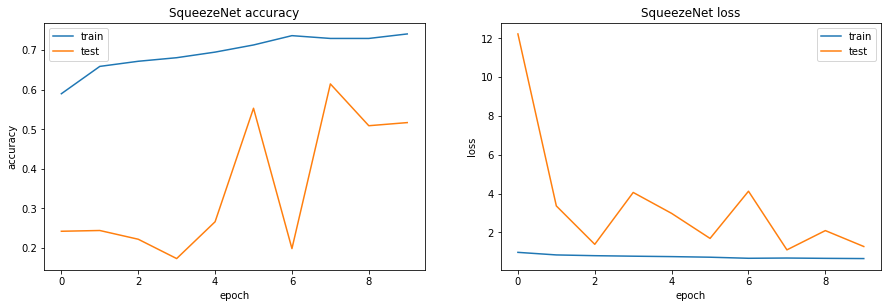

In [26]:
plot_accuracy_and_loss(history)

# Save Model Weights And Configuration

In [27]:
# save model architecture
model_json = model.to_json()
open('xception_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_xception.h5', overwrite=True)

## Next Lesson
###  CGAN: Conditional Generative Adversarial Networks

<img src="../../images/divider.png" width="100">